In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator
from Utilities.basic_units import radians
from src.Den import DENorbits as orb
from Utilities import sections as sec
from Utilities import prelude as prel

from Utilities.operators import make_tree, to_cylindric, Ryan_sampler
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

<Figure size 2400x1800 with 0 Axes>

In [2]:
G = 1
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5
check = 'Low' # '' or 'HiRes' or 'Res20'
check1 = 'HiRes' 
compton = 'Compton'

folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}{compton}'

snap = '164'
snap2 = '164'
path = f'TDE/{folder}{check}/{snap}'
path1 = f'TDE/{folder}{check1}/{snap}'
#saving_path = f'Figs/{folder}/{check}'
#print(f'We are in: {path}, \nWe save in: {saving_path}')
threshold=1/3

Rt = Rstar * (Mbh/mstar)**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rt
apo = Rt**2 / Rstar #2 * Rt * (Mbh/mstar)**(1/3)
params = [Mbh, Rstar, mstar, beta]

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))
c = 3e8 / (7e8/t)

Rg = G*Mbh / c**2

# cfr tidal disruption and at smoothing lenght
xcfr, ycfr, cfr = orb.make_cfr(Rt)
xcfrcut, ycfrcut, cfrcut = orb.make_cfr(1.5*Rt)
xcfr0, ycfr0, cfr0 = orb.make_cfr(R0)

theta_lim = np.pi#3*np.pi/4
step = 0.02
theta_init = np.arange(-theta_lim, theta_lim, step)
theta_arr = Ryan_sampler(theta_init)

Load data

In [3]:
data = make_tree(path, snap, energy = True)
THETA, RADIUS_cyl = to_cylindric(data.X, data.Y)
R = np.sqrt(data.X**2 + data.Y**2 + data.Z**2)
dim_cell = data.Vol**(1/3) 

tfb = days_since_distruption(f'{path1}/snap_{snap}.h5', m, mstar, Rstar, choose = 'tfb')

data1 = make_tree(path1, snap, energy = True)
THETA1, RADIUS_cyl1 = to_cylindric(data1.X, data1.Y)
R1 = np.sqrt(data1.X**2 + data1.Y**2 + data1.Z**2)
dim_cell1 = data1.Vol**(1/3) 
midplane = np.abs(data.Z) < dim_cell
X_midplane, Y_midplane, Z_midplane, dim_midplane, Mass_midplane, Den_midplane, = \
    sec.make_slices([data.X, data.Y, data.Z, dim_cell, data.Mass, data.Den], midplane)

In [8]:
t_fall = 40 * np.power(Mbh/1e6, 1/2) * np.power(mstar,-1) * np.power(Rstar, 3/2) 
#tfb*t_fall is in days
t_sec = tfb*t_fall * 24 * 3600 #s

In [11]:
innner_sphere = R<R0
innner_sphere1 = R1<R0
E_diss_sim, R_inside, M_inside = data.Diss[innner_sphere], R[innner_sphere], data.Mass[innner_sphere]
energytime = np.sum(E_diss_sim*data.Vol[innner_sphere]) #energy/time in sim units
energytime_cgs = energytime*prel.en_converter/prel.t #erg/s
Ediss1_sim, R1_inside, M1_inside = data1.Diss[innner_sphere1], R1[innner_sphere1], data1.Mass[innner_sphere1]
energy1time = np.sum(Ediss1_sim*data1.Vol[innner_sphere1])
energy1time_cgs = energy1time*prel.en_converter/prel.t
print(f'Energy dissipated in the inner sphere at t={np.round(tfb,2)}: \nLow: {energytime_cgs} \nHigh: {energy1time_cgs}')

E_th = np.sum(G*Mbh*M_inside/R_inside) #energy
E_th_cgs = E_th*prel.en_converter #erg
E_th1 = np.sum(G*Mbh*M1_inside/R1_inside) 
E_th1_cgs = E_th1*prel.en_converter #erg
Ediss_th = E_th_cgs/t_sec
Ediss_th1 = E_th1_cgs/t_sec
print(f'Theoretical energy dissipated in the inner sphere at t={np.round(tfb,2)}: \nLow: {Ediss_th} \nHigh: {Ediss_th1}')

print(f'Ratio: {energytime_cgs/Ediss_th} \nRatio1: {energy1time_cgs/Ediss_th1}')

Energy dissipated in the inner sphere at t=0.52: 
Low: -1.4729107499363456e+39 
High: -8.346823710769715e+38
Theoretical energy dissipated in the inner sphere at t=0.52: 
Low: 8.327965693018111e+39 
High: 1.4921186102103232e+39
Ratio: -0.176863210564278 
Ratio1: -0.5593941161013453


Midplane 

In [93]:
midplane1 = np.abs(data1.Z) < dim_cell1
X_midplane1, Y_midplane1, Z_midplane1, dim_midplane1, Mass_midplane1, Den_midplane1 = \
    sec.make_slices([data1.X, data1.Y, data1.Z, dim_cell1, data1.Mass, data1.Den], midplane1)

Tangent and transverse plane

In [94]:
# check if the file with the data exist and load it
streamLow = np.load(f'data/{folder}/DENstream_{check}{snap}.npy')
theta_arr, x_stream, y_stream, z_stream = streamLow[0], streamLow[1], streamLow[2], streamLow[3]
streamMiddle = np.load(f'data/{folder}/DENstream_{check1}{snap}.npy')
x_stream1, y_stream1, z_stream1 = streamMiddle[1], streamMiddle[2], streamMiddle[3]
    

In [121]:
# line x = y
xpi4 = np.linspace(0, 40, 100)

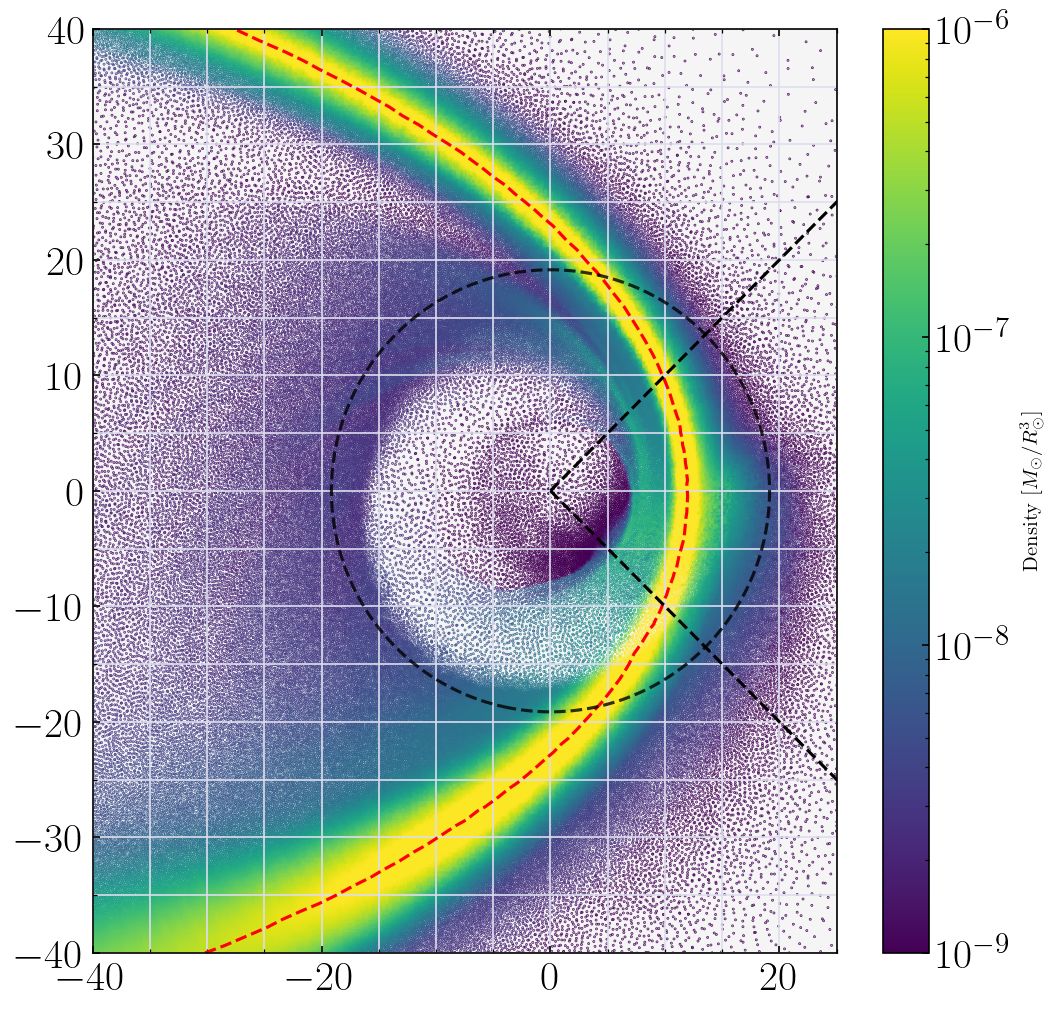

In [131]:
plt.figure(figsize=(8,8))
img = plt.scatter(X_midplane1, Y_midplane1, c = Den_midplane1, s = .1, cmap = 'viridis', norm= colors.LogNorm(vmin = 1e-9, vmax = 1e-6))
plt.colorbar(img, label = r'Density [$M_\odot/R_\odot^3$]')
plt.plot(x_stream1[:230], y_stream1[:230], '--', c = 'r')
plt.contour(xcfrcut, ycfrcut, cfrcut, [0], linestyles = '--', colors = 'k', alpha = 0.8)
plt.plot(xpi4, xpi4, '--', c = 'k')
plt.plot(xpi4, -xpi4, '--', c = 'k')
plt.tick_params(axis = 'both', which = 'minor', direction='in', labelsize=6)
plt.xlim(-40,25)
plt.ylim(-40,40)
plt.gca().yaxis.set_major_locator(MultipleLocator(10))
plt.gca().yaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(True, 'both', color='#ddddee') # use a lighter color
plt.savefig(f'Figs/{folder}/understandcut.png')

In [132]:
idx = np.argmin(np.abs(theta_arr))
theta_chosen = theta_arr[idx]
x_chosen, y_chosen, z_chosen = x_stream[idx], y_stream[idx], z_stream[idx]
x_chosen1, y_chosen1, z_chosen1 = x_stream1[idx], y_stream1[idx], z_stream1[idx]

condition_tra, x_onplane, x0 = sec.transverse_plane(data.X, data.Y, data.Z, dim_cell, x_stream, y_stream, z_stream, idx, coord= True)
X_tra, Y_tra, Z_tra, Den_tra, Mass_tra, dim_cell_tra = \
    sec.make_slices([data.X, data.Y, data.Z, data.Den, data.Mass, dim_cell], condition_tra)
den_cut = Den_tra>1e-9
X_tra, x_onplane, Y_tra, Z_tra, Den_tra, Mass_tra, dim_cell_tra = \
    sec.make_slices([X_tra, x_onplane, Y_tra, Z_tra, Den_tra, Mass_tra, dim_cell_tra], den_cut)

# do the same for data1
condition_tra1, x_onplane1, x01 = sec.transverse_plane(data1.X, data1.Y, data1.Z, dim_cell1, x_stream1, y_stream1, z_stream1, idx, coord= True)
X_tra1, Y_tra1, Z_tra1, Den_tra1, Mass_tra1, dim_cell_tra1 = \
    sec.make_slices([data1.X, data1.Y, data1.Z, data1.Den, data1.Mass, dim_cell1], condition_tra1)
den_cut1 = Den_tra1>1e-9
X_tra1, x_onplane1, Y_tra1, Z_tra1, Den_tra1, Mass_tra1, dim_cell_tra1 = \
    sec.make_slices([X_tra1, x_onplane1, Y_tra1, Z_tra1, Den_tra1, Mass_tra1, dim_cell_tra1], den_cut1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


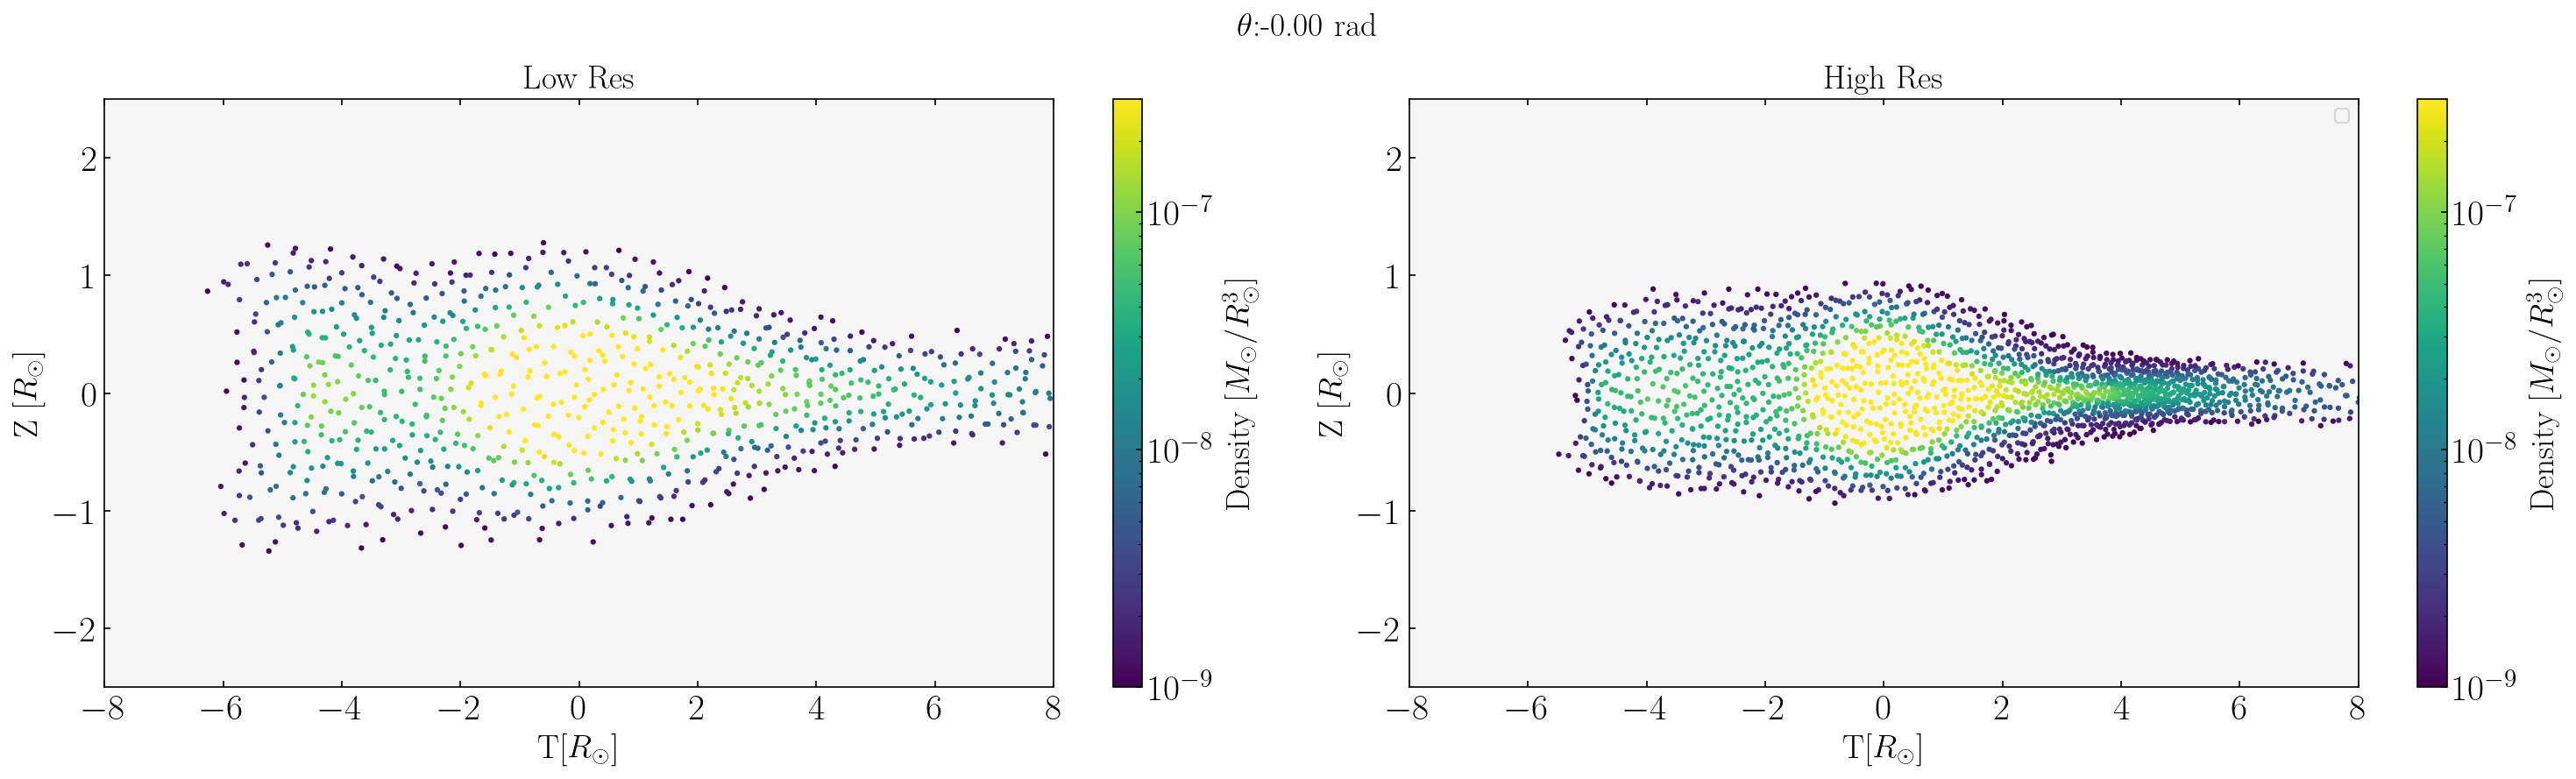

In [133]:
# Plotting density
fig, ax = plt.subplots(1,2, figsize = (20,6))
img1 = ax[0].scatter(x_onplane, Z_tra, c = Den_tra,  cmap = 'viridis', s = 4, norm = colors.LogNorm(vmin = 1e-9, vmax = 3e-7))#np.max(Den_tra)))
cbar1 = plt.colorbar(img1)
cbar1.set_label(r' Density [$M_\odot/R_\odot^3$]', fontsize = 18)
# ax[0].scatter(0, z_stream[idx], marker = 'x', s = 37, c = 'k', alpha = 1)
ax[0].set_title('Low Res', fontsize = 18)

img1 = ax[1].scatter(x_onplane1, Z_tra1, c = Den_tra1,  cmap = 'viridis', s = 4, norm = colors.LogNorm(vmin = 1e-9, vmax = 3e-7))#np.max(Den_tra1)))
cbar1 = plt.colorbar(img1)
cbar1.set_label(r' Density [$M_\odot/R_\odot^3$]', fontsize = 18)
# ax[1].scatter(0, z_stream1[idx], marker = 'x', s = 37, c = 'k', alpha = 1)
ax[1].set_title('High Res', fontsize = 18)
for i in range(2):
    ax[i].set_xlim(-8,8)#xlim_neg, xlim)
    ax[i].set_ylim(-2.5, 2.5)#ylim_neg, ylim)
    ax[i].set_xlabel(r'T[$R_\odot$]', fontsize = 18)
    ax[i].set_ylabel(r'Z [$R_\odot$]', fontsize = 18)
ax[1].legend()
plt.suptitle(r'$\theta$:' + f'{theta_chosen:.2f} rad', fontsize = 18)
plt.tight_layout()
plt.savefig(f'Figs/{folder}/multiple/transversesliceDen{np.round(theta_chosen,1)}.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


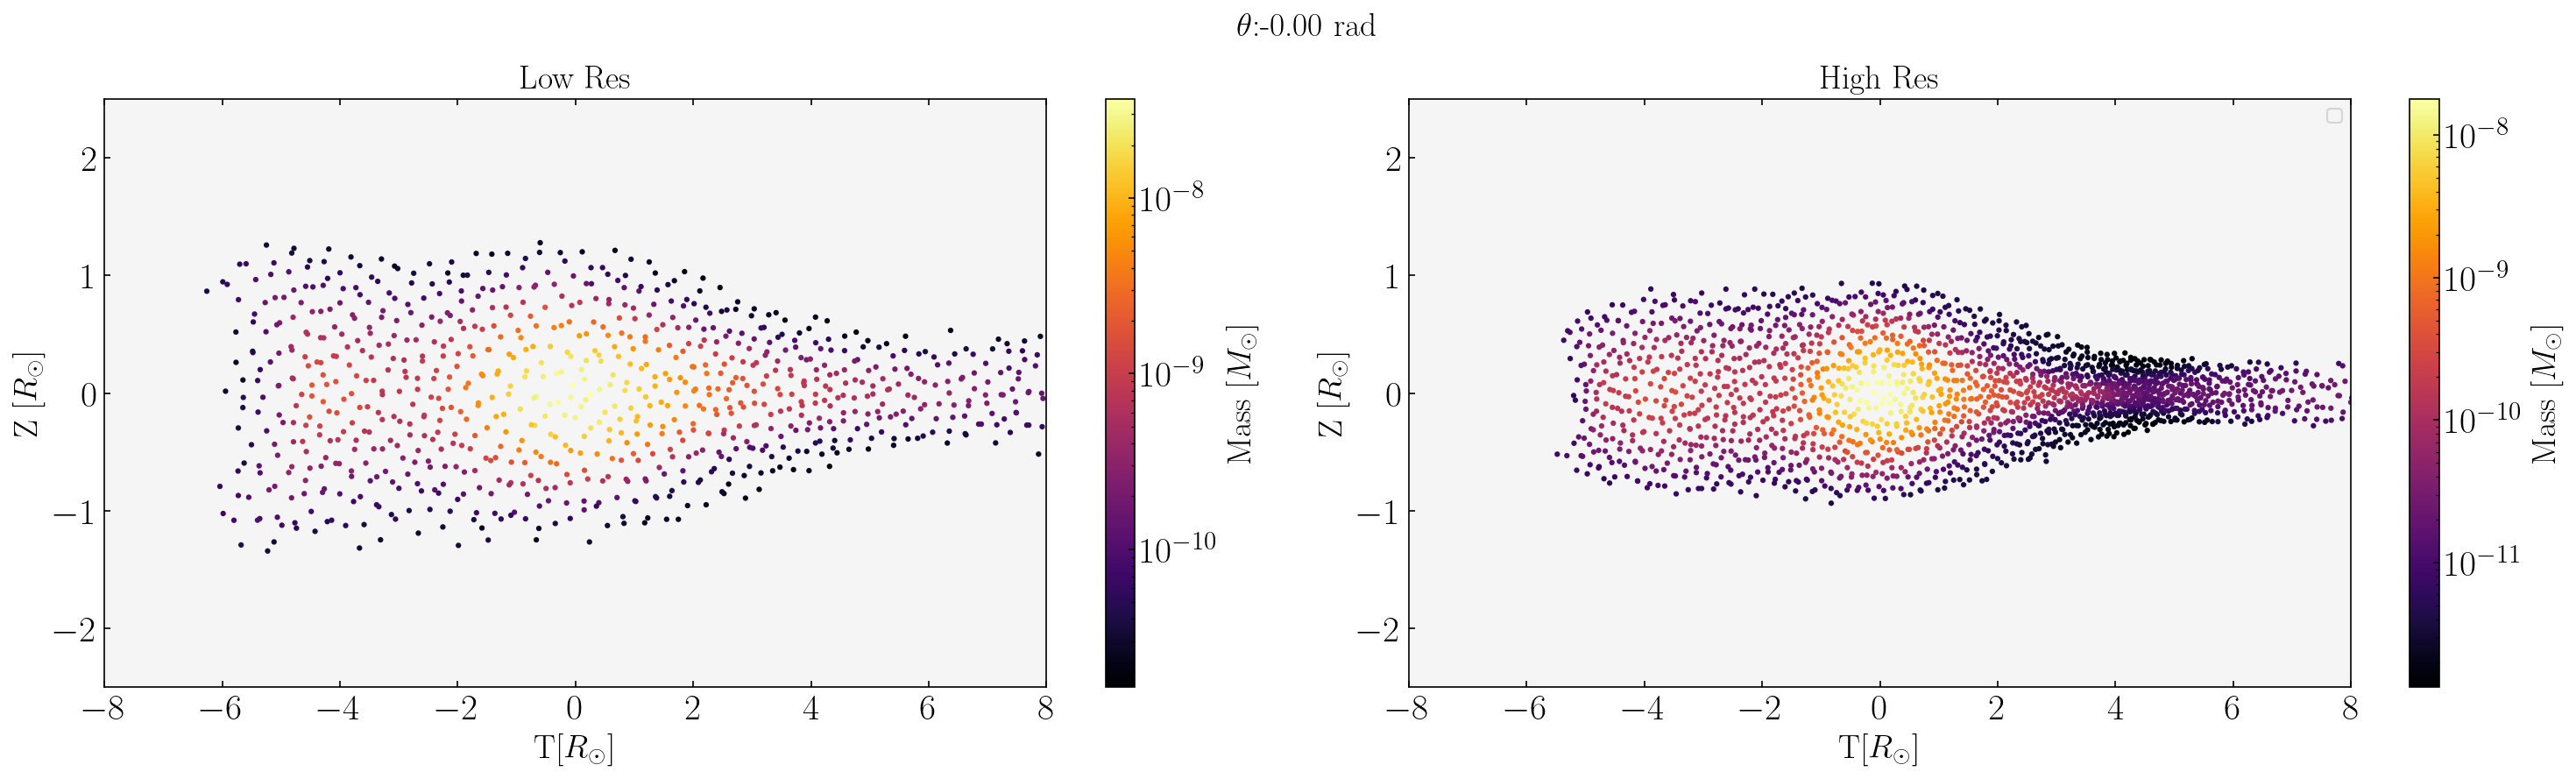

In [134]:
# Plotting mass
fig, ax = plt.subplots(1,2, figsize = (20,6))
img1 = ax[0].scatter(x_onplane, Z_tra, c = Mass_tra,  cmap = 'inferno', s = 4, norm = colors.LogNorm(vmin = np.min(Mass_tra), vmax = np.max(Mass_tra)))
cbar1 = plt.colorbar(img1)
cbar1.set_label(r'Mass [$M_\odot$]', fontsize = 18)
# ax[0].scatter(0, z_stream[idx], marker = 'x', s = 37, c = 'k', alpha = 1)
ax[0].set_title('Low Res', fontsize = 18)

img1 = ax[1].scatter(x_onplane1, Z_tra1, c = Mass_tra1,  cmap = 'inferno', s = 4, norm = colors.LogNorm(vmin = np.min(Mass_tra1), vmax = np.max(Mass_tra1)))
cbar1 = plt.colorbar(img1)
cbar1.set_label(r' Mass [$M_\odot$]', fontsize = 18)
# ax[1].scatter(0, z_stream1[idx], marker = 'x', s = 37, c = 'k', alpha = 1)
ax[1].set_title('High Res', fontsize = 18)
for i in range(2):
    ax[i].set_xlim(-8,8)#xlim_neg, xlim)
    ax[i].set_ylim(-2.5, 2.5)#ylim_neg, ylim)
    ax[i].set_xlabel(r'T[$R_\odot$]', fontsize = 18)
    ax[i].set_ylabel(r'Z [$R_\odot$]', fontsize = 18)
ax[1].legend()
plt.suptitle(r'$\theta$:' + f'{theta_chosen:.2f} rad', fontsize = 18)
plt.tight_layout()
plt.savefig(f'Figs/{folder}/multiple/transversesliceMass{np.round(theta_chosen,1)}.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


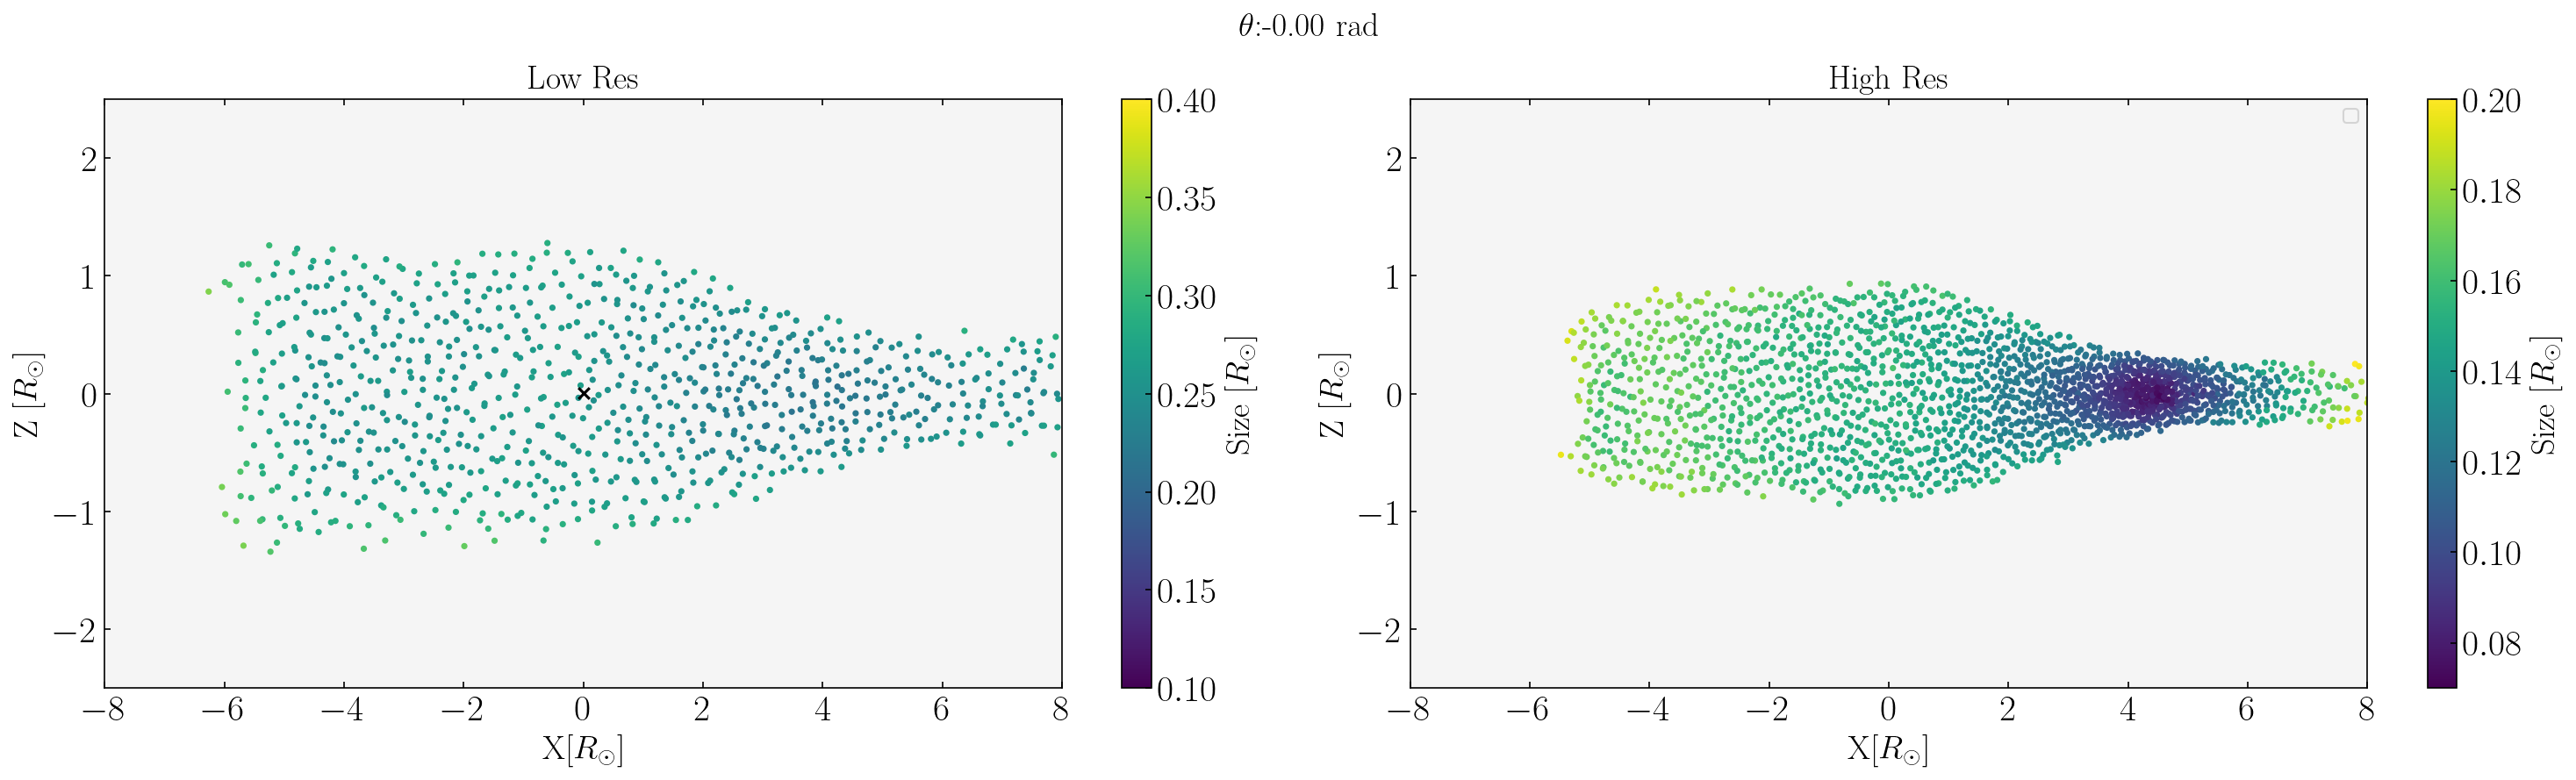

In [135]:
# Plotting size
fig, ax = plt.subplots(1,2, figsize = (20,6))
img1 = ax[0].scatter(x_onplane, Z_tra, c = dim_cell_tra,  cmap = 'viridis', s = 6, vmin = 1e-1, vmax = 4e-1)
cbar1 = plt.colorbar(img1)
cbar1.set_label(r'Size [$R_\odot$]', fontsize = 18)
ax[0].scatter(0, z_stream[idx], marker = 'x', s = 37, c = 'k', alpha = 1)
ax[0].set_title('Low Res', fontsize = 18)

img1 = ax[1].scatter(x_onplane1, Z_tra1, c = dim_cell_tra1,  cmap = 'viridis', s = 6, vmin = 7e-2, vmax = 2e-1)
cbar1 = plt.colorbar(img1)
cbar1.set_label(r' Size [$R_\odot$]', fontsize = 18)
# ax[1].scatter(0, z_stream1[idx], marker = 'x', s = 37, c = 'k', alpha = 1)
ax[1].set_title('High Res', fontsize = 18)
for i in range(2):
    ax[i].set_xlim(-8,8)#xlim_neg, xlim)
    ax[i].set_ylim(-2.5, 2.5)#ylim_neg, ylim)
    ax[i].set_xlabel(r'X[$R_\odot$]', fontsize = 18)
    ax[i].set_ylabel(r'Z [$R_\odot$]', fontsize = 18)
ax[1].legend()
plt.suptitle(r'$\theta$:' + f'{theta_chosen:.2f} rad', fontsize = 18)
plt.tight_layout()
plt.savefig(f'Figs/{folder}/multiple/transversesliceSize{np.round(theta_chosen,1)}.png')